In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [4]:
# Dataset URL: https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv

In [5]:
train = pd.read_csv("covid2train.csv", index_col = 0)

In [6]:
features = ['age', 'sex', 'country', 'chronic_disease_binary', 'que_paso']
xtrain = train[features]

In [7]:
#train.info()

In [8]:
def clean(train):
    features = ['age', 'sex', 'country', 'chronic_disease_binary', 'que_paso']
    xtrain = train[features]

# Dropping NA's from only 'sex' + 'country'    
    subset = xtrain.dropna(subset = ['age','sex','country'])
    countries = xtrain['country'].drop_duplicates().dropna()

# Replacing the age ranges with their means    
    mp = {'20-29': np.mean([20,29]), '40-49': np.mean([40,49]),'50-59': np.mean([50,59]),
          '60-69': np.mean([60,69]), '70-79': np.mean([70,79]),
          '80-89': np.mean([80,89]),'90-99': np.mean([90,99]), '80-': 80}
    
# Dictionary replacing countries with numerical values
    mp2 = {}
    key = np.arange(len(countries) + 1)
    for i,j in zip(countries,key):
        val = {i:j}
        mp2.update(val)
        
    mp3 = {'male': 0, 'female': 1}
        
# Updating the training data with new values
    subset = subset.replace(mp).replace(mp2).replace(mp3)
    subset['chronic_disease_binary'] = subset['chronic_disease_binary']*1
    subset['age'] = subset['age'].astype(float)
    
    xtrain = subset
    ytrain = subset['que_paso']
    return xtrain, ytrain, mp2

In [9]:
xtrain, ytrain, mp2 = clean(train)

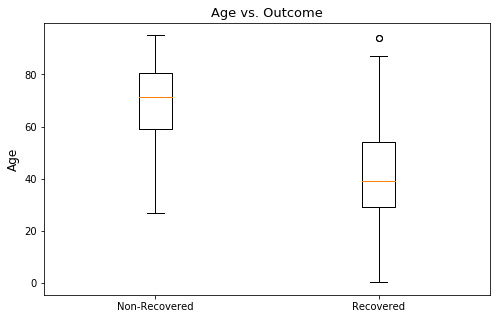

In [10]:
age_death = xtrain['que_paso'] == 0
age_rec = xtrain['que_paso'] == 1

xdeath = xtrain[age_death]
xrec = xtrain[age_rec]

age1 = xdeath['age']
age2 = xrec['age']

data = [age1, age2]
fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Age vs. Outcome', fontsize = 13)

ax.boxplot(data, labels = ['Non-Recovered', 'Recovered'])
ax.set_ylabel("Age", fontsize = 12)
plt.show()

In [11]:
xtrain2 = xtrain.drop('que_paso', axis = 1)

In [12]:
from sklearn.ensemble import RandomForestClassifier 

clf =  RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True, random_state=42)

clf.fit(xtrain2, ytrain)

var_imp = clf.feature_importances_
var = ['Age', 'Sex', 'Country', 'Chronic Disease']

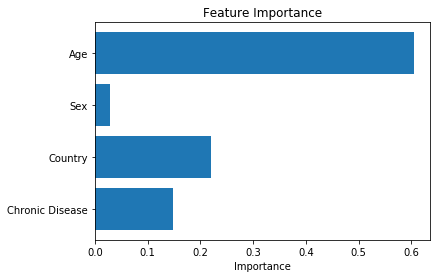

In [13]:
fig, ax = plt.subplots(figsize = (6,4))

y_pos = np.arange(len(var))

ax.barh(y_pos, var_imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(var)
ax.invert_yaxis() 
ax.set_xlabel('Importance', fontsize = 10)
ax.set_title('Feature Importance', fontsize = 12)

plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
plt.style.use('default')

In [19]:
clfs = {"SVM": SVC(C = 50, kernel = 'rbf', gamma = 'auto', probability = True),
    "Random Forest": RandomForestClassifier(n_estimators = 500,
                           n_jobs = -1, min_samples_leaf = 2,
                           bootstrap = True, random_state = 42),
    "Logistic Regression": LogisticRegression(solver = 'saga',
                                             random_state = 42)}

In [46]:
def classifier(data, clfs_dict):
    selection = 0
    X = data.drop(["que_paso"], axis = 1)
    y = data.iloc[:,-1] 
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.5)
    scaler = StandardScaler()
    scaler.fit(xtrain)
    scaler.fit(xtest)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
#     while selection != 4:
#         print("1. SVM")
#         print("2. Random Forest")
#         print("3. Logistic Regression")
#         print("4. Quit")
#         selection = int(input("Choose your ML method: "))
        
#         if selection == 4:
#             print("Goodbye!")
#             break
            
#         else:

    ML = list(clfs_dict.values())
    names = list(clfs_dict.keys())
        
    for i in ML:
        clf = i.fit(xtrain,ytrain)
        yprob = clf.predict_proba(xtest)[::,1]
        ypred = clf.predict(xtest)
        fpr, tpr, thresholds = metrics.roc_curve(ytest, yprob)
        auc = round(metrics.auc(fpr,tpr),4)
        acc = round(accuracy_score(ytest, ypred),4)
        
        print("The AUC for", names[ML.index(i)], "is", auc) 
        print("The accuracy score for", names[ML.index(i)], "is", acc)
        
        plt.plot(fpr, tpr, lw = 1, label = names[ML.index(i)]) # + '. AUC: '+ str(auc))
        plt.plot([0, 1], [0, 1], color = 'navy', lw = 1, linestyle = '--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.title("ROC Curve")

The AUC for SVM is 0.8967
The accuracy score for SVM is 0.8516
The AUC for Random Forest is 0.9429
The accuracy score for Random Forest is 0.8665
The AUC for Logistic Regression is 0.9096
The accuracy score for Logistic Regression is 0.8665


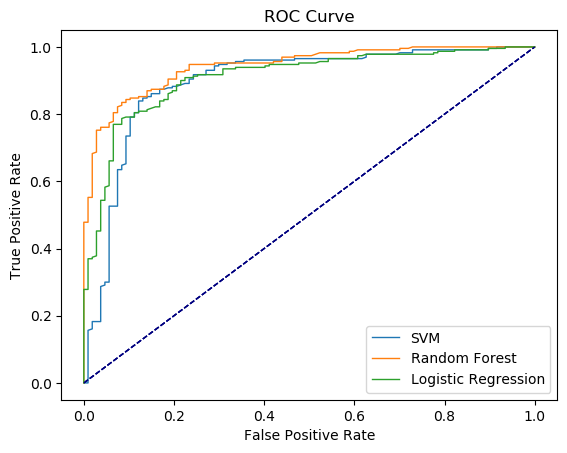

In [47]:
classifier(xtrain, clfs)